<h1><p style="text-align:center">Vehicle Fuel Efficiency Analysis and Modelling</p></h1>

## Business Context

Fuel Economy is a key driver of total cost of ownership, pricing competitiveness, and regulatory compliance in the automotive industry.

Consumer Reports Magazine, a trusted source for information on consumer products and services seeks to understand which vehicle characteristics influence fuel efficiency.

## Business Problem

Fuel economy is a critical driver of vehicle ownership cost and a key consideration for consumers. To support an upcoming article and inform strategic decision-making, the organization seeks to analyze how automobile characteristics influence fuel efficiency.

Specifically, the organization aims to:

* Identify the vehicle attributes that has the greatest impact on fuel economy
* Develop a predict model to estimate fuel economy based on vehicle characterisitics
* Translate analytical and modelling results into actionable insights to inform product positioning, pricing strategies, and consumer guidance.

## Analytical Objective

Prepare and explore data, build and evaluate a multiple linear regression model to predict vehicle fuel efficiency(MPG), and interpret model outputs.

## Data Overview

Field  |  Description
------- | -----------
mpg  | The fuel economy of the car in terms of miles travelled per gallon of gasoline
cylinders | The number of cylinders in the car's engine
displacement | The volume of air displaced by all the pistons of a piston engine
horsepower | Horsepower is a measure of power the engine produces
weight | The total weight of the car
acceleration | The time in seconds it takes for the car to reach 60 miles per hour
model year | The year (in the 20th century) the car model was released
origin | The region where the car was manufactured. 1 - USA. 2 - Europe. 3 - Japan
car name | The name of the car model.

In [1]:
# import libraries
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
import scipy.stats as stats
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error as mae, r2_score as r2

In [2]:
# set plotting theme
sns.set_theme(style="darkgrid")

In [3]:
# load data
file = "auto-mpg.csv"
auto_df = pd.read_csv(file)

# display few rows of data
auto_df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [4]:
auto_df.tail()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
393,27.0,4,140.0,86,2790,15.6,82,1,ford mustang gl
394,44.0,4,97.0,52,2130,24.6,82,2,vw pickup
395,32.0,4,135.0,84,2295,11.6,82,1,dodge rampage
396,28.0,4,120.0,79,2625,18.6,82,1,ford ranger
397,31.0,4,119.0,82,2720,19.4,82,1,chevy s-10


In [5]:
# Dataframe info
auto_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 28.1+ KB


In [6]:
# Check for duplicated rows
auto_df.duplicated().sum()

np.int64(0)

In [7]:
# Descriptive statistics of the dataframe
auto_df.describe()

,mpg,cylinders,displacement,weight,acceleration,model year,origin
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,5140.000000,24.800000,82.000000,3.000000


In [8]:
auto_df.describe(include="object")

,horsepower,car name
count,398,398
unique,94,305
top,150,ford pinto
freq,22,6


From the initial inspection, no much cleaning to be done in this data, except the `origin` and `horsepower` columns that has wrong datatype.
For the `model year` column, since the years are in 20th Century, I will prefix `19` to each value for proper year identification.

# Data Cleaning

In [9]:
# rename columns
auto_df.rename(columns={"model year":"model_year", "car name":"car_name"}, inplace=True)

In [10]:
auto_df.origin.unique()

array([1, 3, 2])

In [11]:
# map string to values in origin column

origin_map = {
    1:"USA",
    2:"Europe",
    3:"Japan"
}

auto_df = auto_df.assign(
    origin = auto_df.origin.map(origin_map),
    horsepower = pd.to_numeric(auto_df.horsepower, errors="coerce")
)

In [12]:
# Replacing missing values in horsepower with the median
auto_df["horsepower"] = auto_df["horsepower"].fillna(np.mean(auto_df.horsepower))

In [13]:
# Prefix 19 to model_year values
auto_df["model_year"] = ("19" + auto_df["model_year"].astype(str)).astype(int)

In [14]:
auto_df.model_year.unique()

array([1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980,
       1981, 1982])

# Exploratory Data Analysis

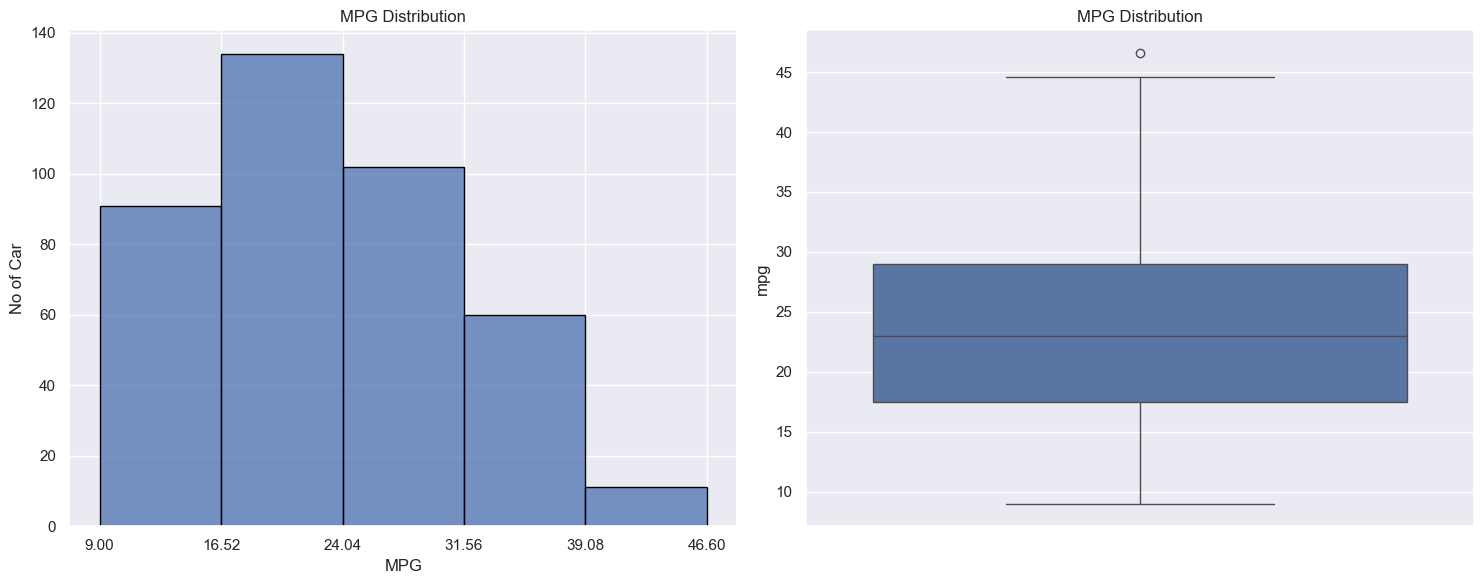

In [15]:
# Target Exploration
count, no_bins = np.histogram(auto_df["mpg"], bins=5)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.histplot(auto_df.mpg, bins=no_bins, edgecolor="black", ax=axes[0])
sns.boxplot(auto_df.mpg, ax=axes[1])

axes[0].set_title("MPG Distribution")
axes[0].set_xlabel("MPG")
axes[0].set_ylabel("No of Car")
axes[0].set_xticks(no_bins)

axes[1].set_title("MPG Distribution")

plt.tight_layout()
plt.show()

## Features Exploration

In [16]:
def explore_numeric(dataframe, features):
    n_cols = 2
    n_rows = len(features)

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))

    for i, col in enumerate(features):
        # First plot in rows
        sns.histplot(data=dataframe, x=col, edgecolor="black", ax=axs[i, 0])

        axs[i, 0].set_title(f"{col} Distribution")
        axs[i, 0].set_ylabel("No of Car")
        axs[i, 0].set_xlabel(col)
        #axes[i, 0].set_xticks(bins)

        # Second plot in row
        sns.boxplot(data=dataframe, x=col, ax=axs[i, 1])

        axs[i, 1].set_title(f"{col} Boxplot")

    plt.tight_layout()
    plt.show()

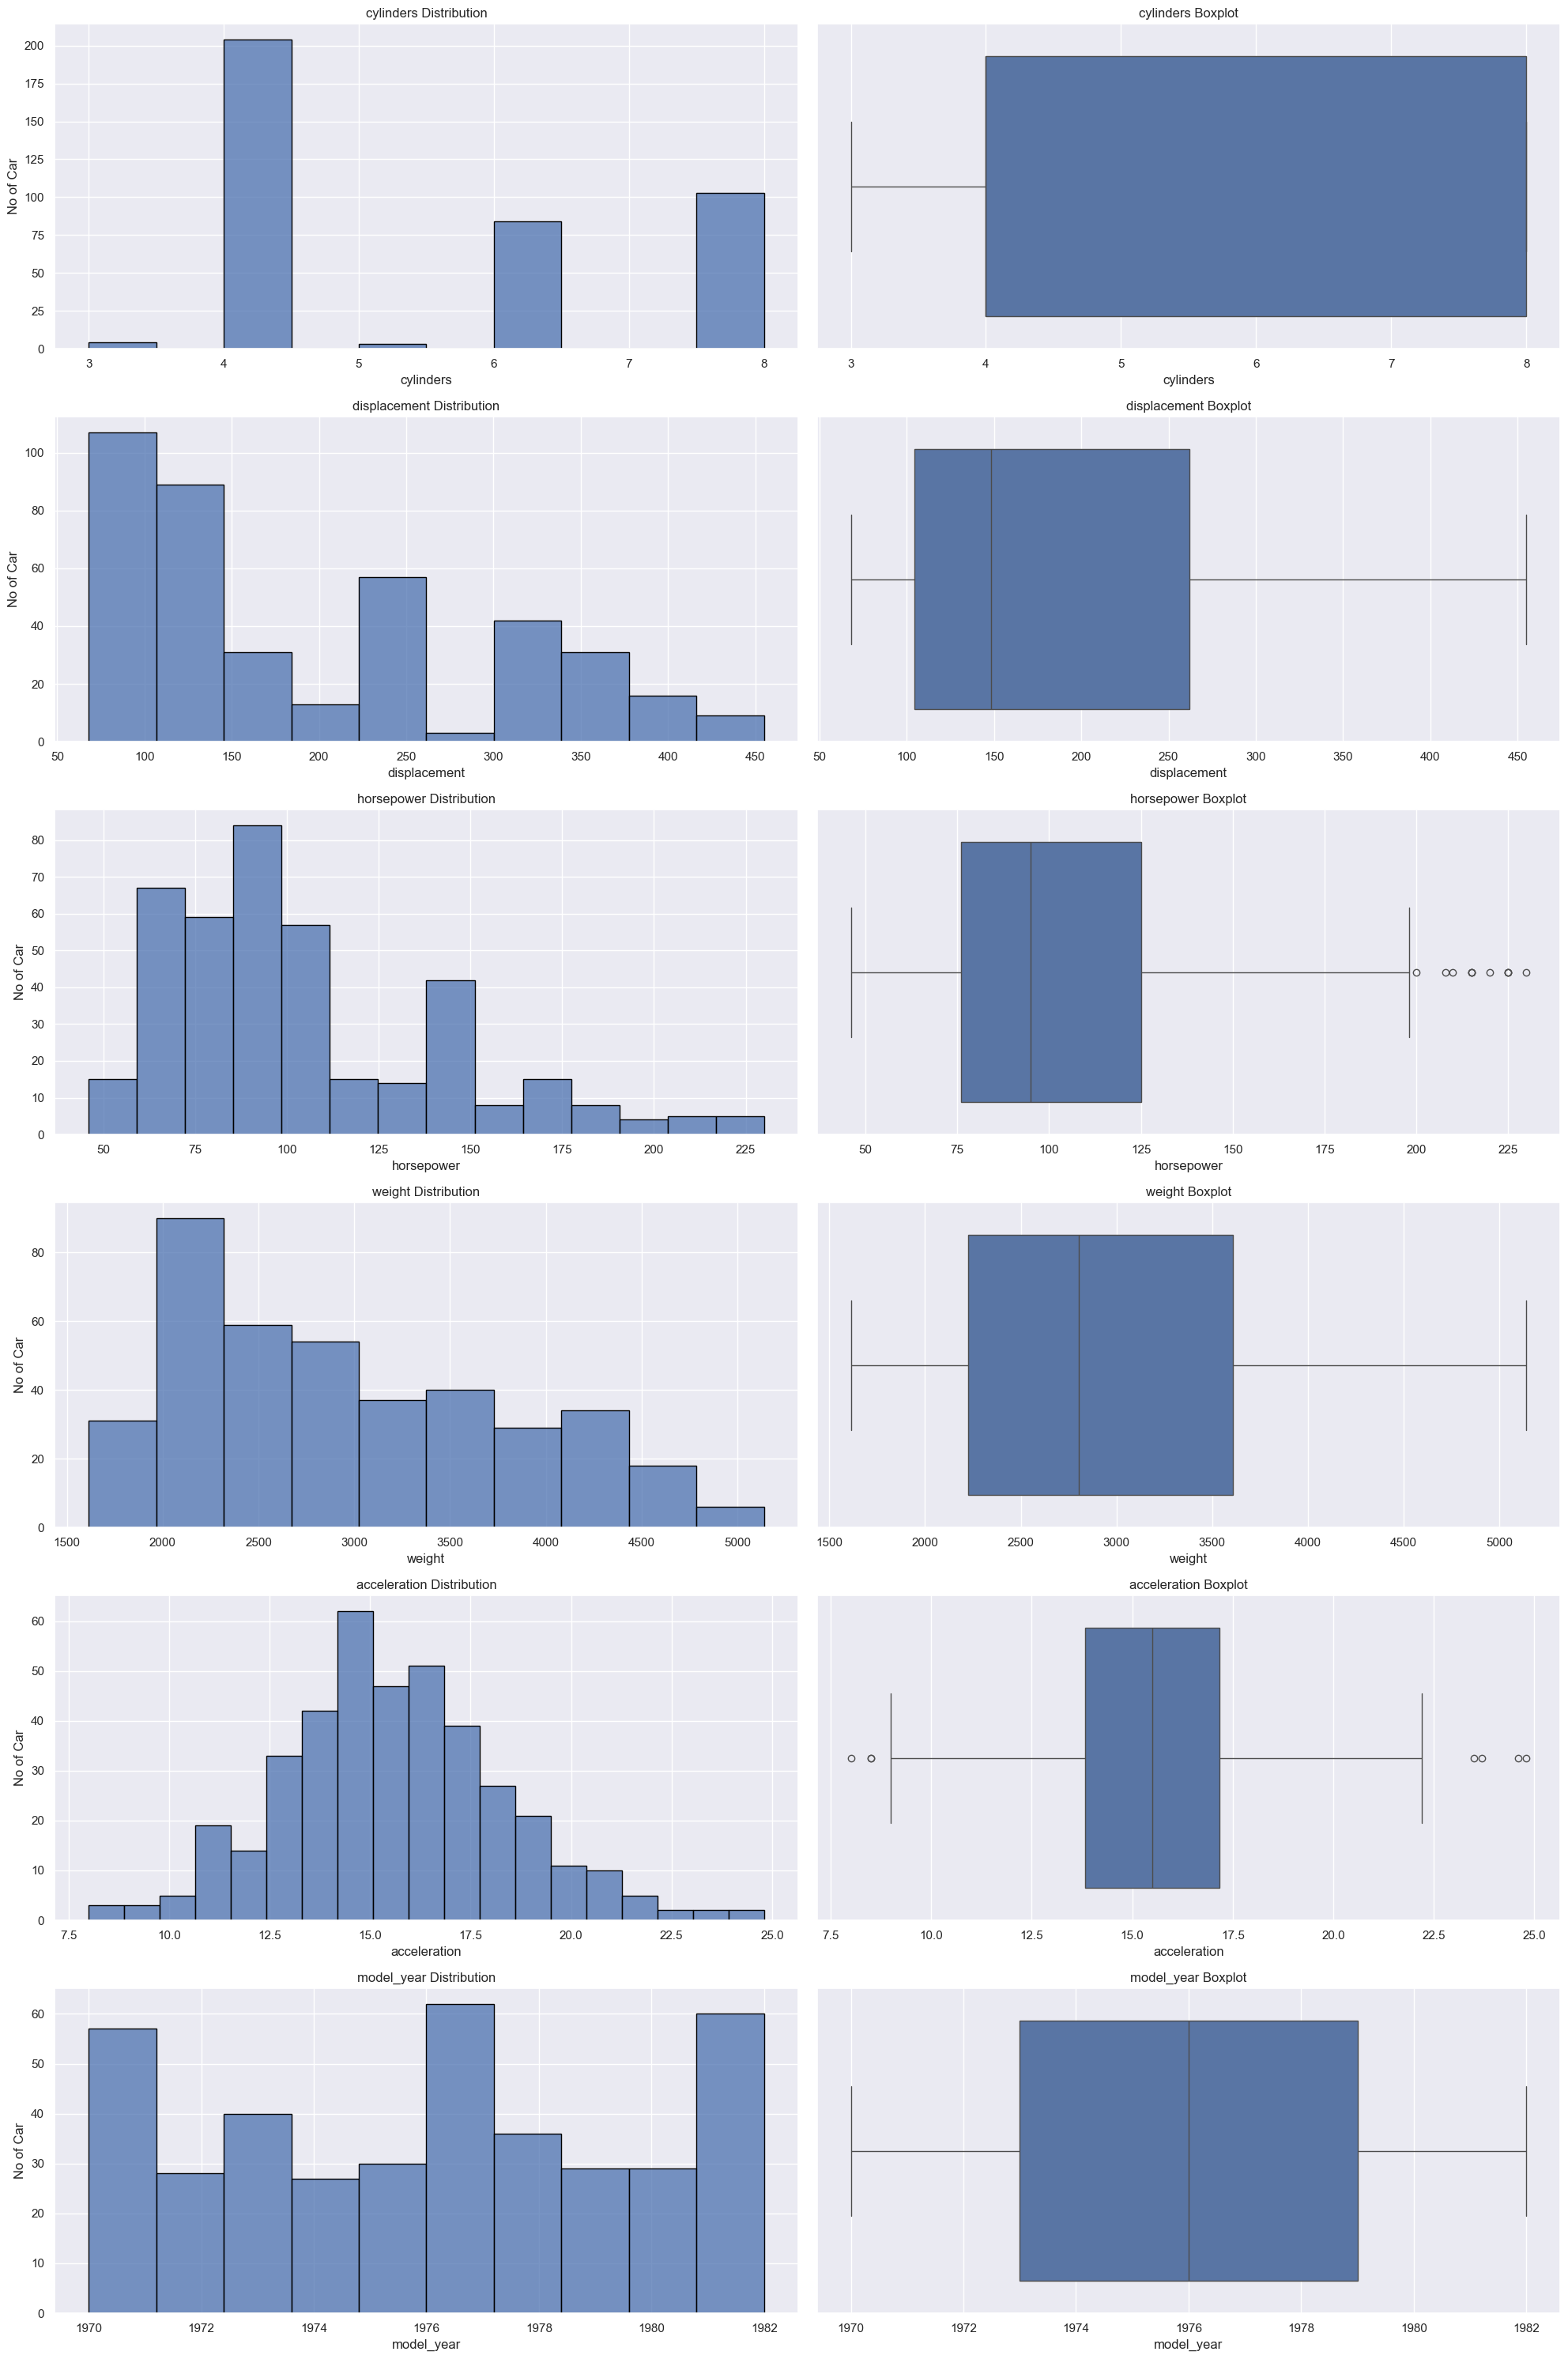

In [17]:
explore_numeric(dataframe=auto_df, features=["cylinders", "displacement", "horsepower", "weight", "acceleration", "model_year"])

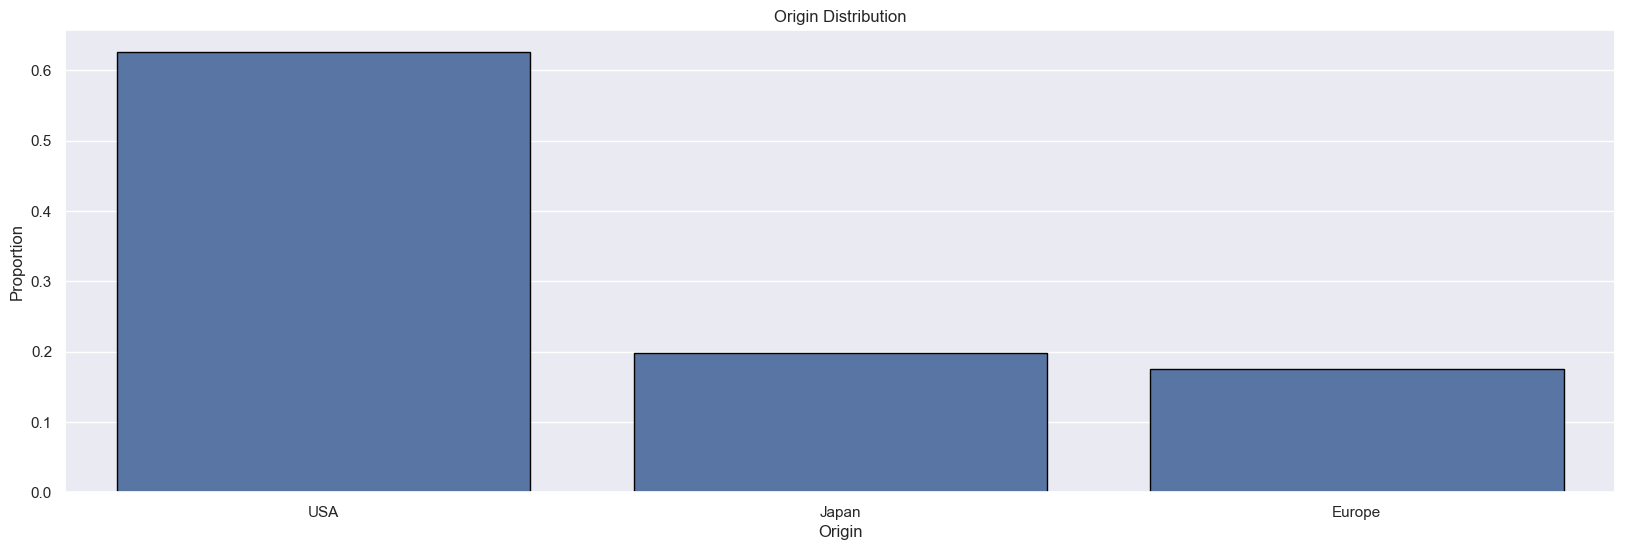

In [18]:
origin_count = auto_df.origin.value_counts(normalize=True)

plt.figure(figsize=(20,6))
sns.barplot(origin_count, edgecolor="black")

plt.title("Origin Distribution")
plt.xlabel("Origin")
plt.ylabel("Proportion");

1. **MPG**: Approximately 82% of the vehicles have fuel efficiency values between 32 and 90 mpg, with an average mpg of 23.
2. **Cylinders**: Out of 398, 200 have 4 cylinders while 3 and 5 cylinders are the least common.
3. **Displacement**: Around 190 vehicles have engine displacement within the range of 60 - 150
4. **Horsepower**: Majority of the vehicles have less than 100 horsepower.
5. **Origin**: Over 60% of vehicles were manufacuterd in USA.

## Feature-Target Exploration

In [19]:
# Numeric variables
def numeric_relationship(dataframe, numeric_features, target="mpg"):
    n_rows = len(numeric_features) // 2
    n_cols = 2

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows), sharey=True)
    axs = axs.flatten()

    for ax, col in zip(axs, numeric_features):
        sns.scatterplot(data=dataframe, x=col, y=target, ax=ax)

        ax.set_title(f"{col} vs {target}")
        ax.set_ylabel(f"{target}")
        ax.set_xlabel(f"{col}")

    plt.tight_layout(pad=4)
    plt.show()

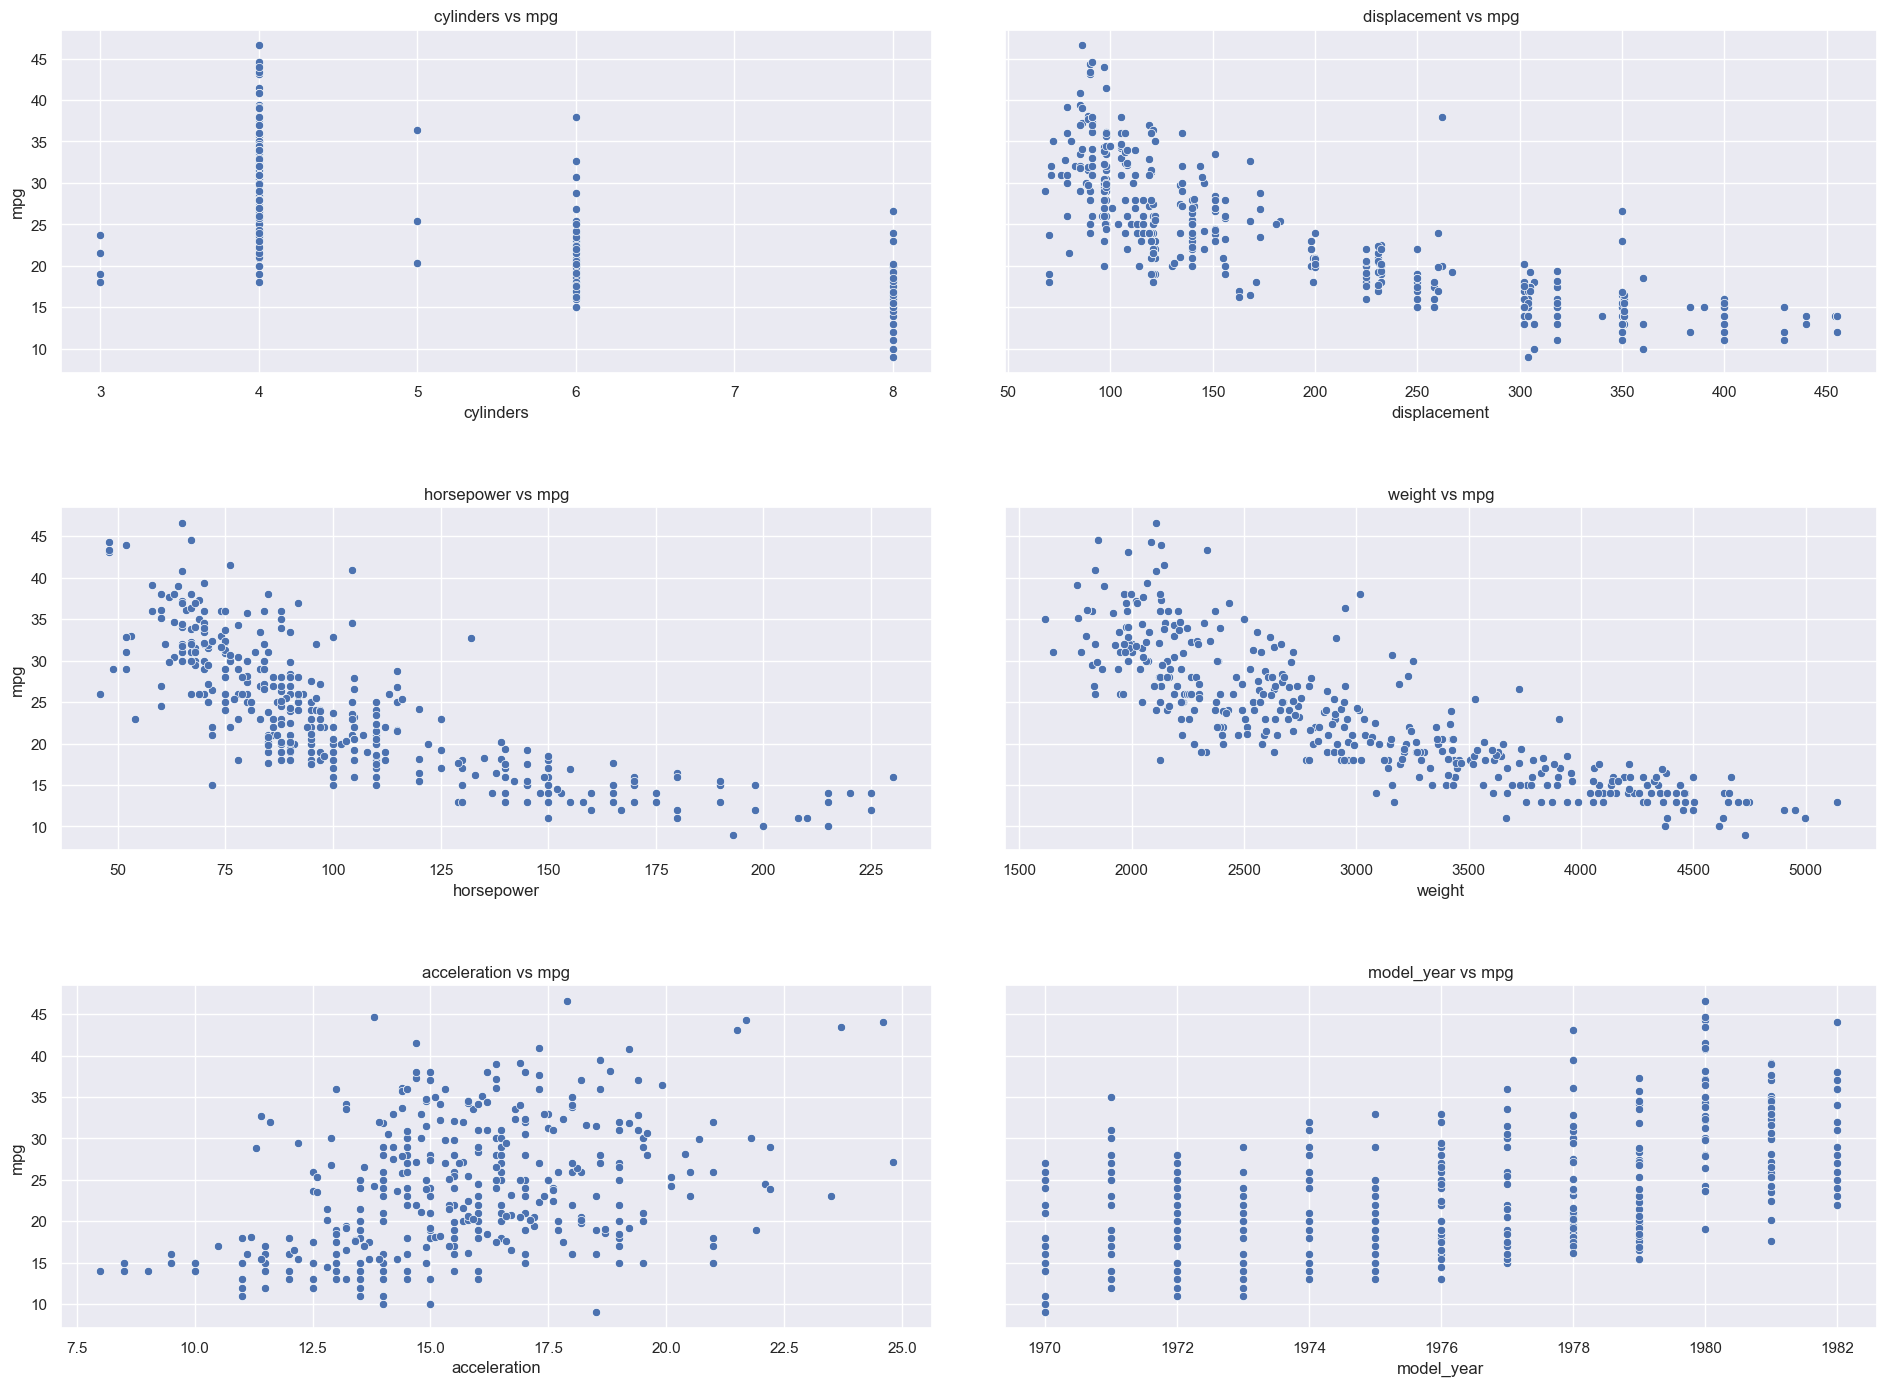

In [20]:
features = auto_df.select_dtypes(include="number").drop("mpg", axis=1).columns

numeric_relationship(dataframe=auto_df, numeric_features=features)

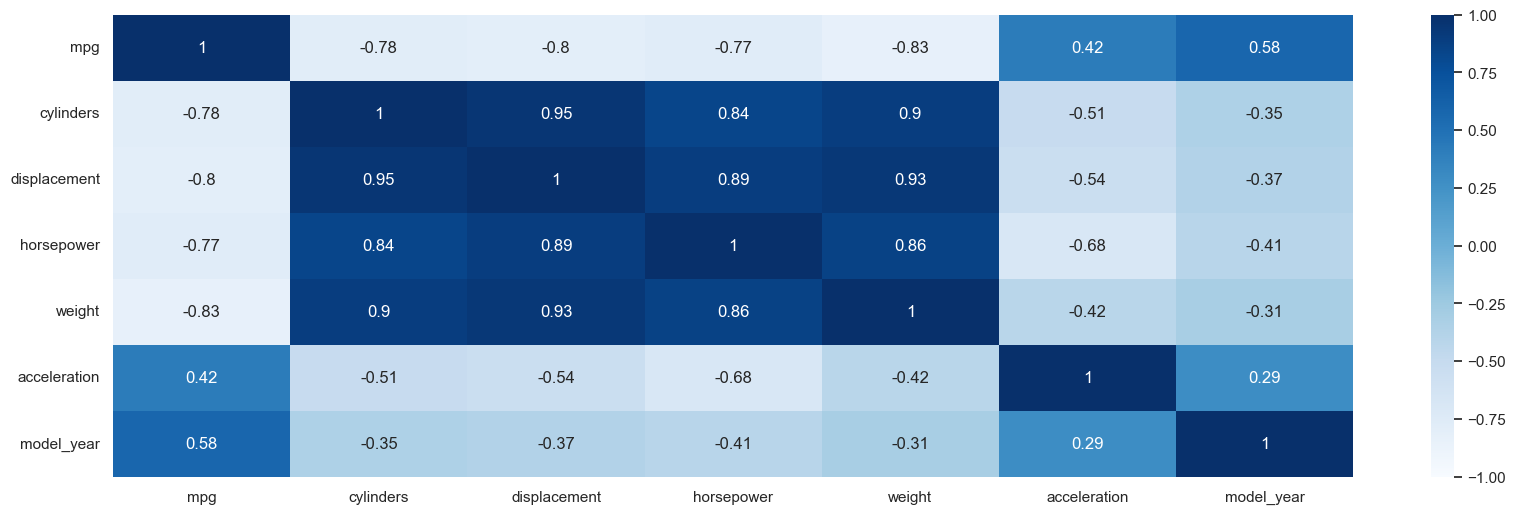

In [21]:
plt.figure(figsize=(20, 6))

sns.heatmap(auto_df.corr(numeric_only=True), vmin=-1, vmax=1, cmap="Blues", annot=True);

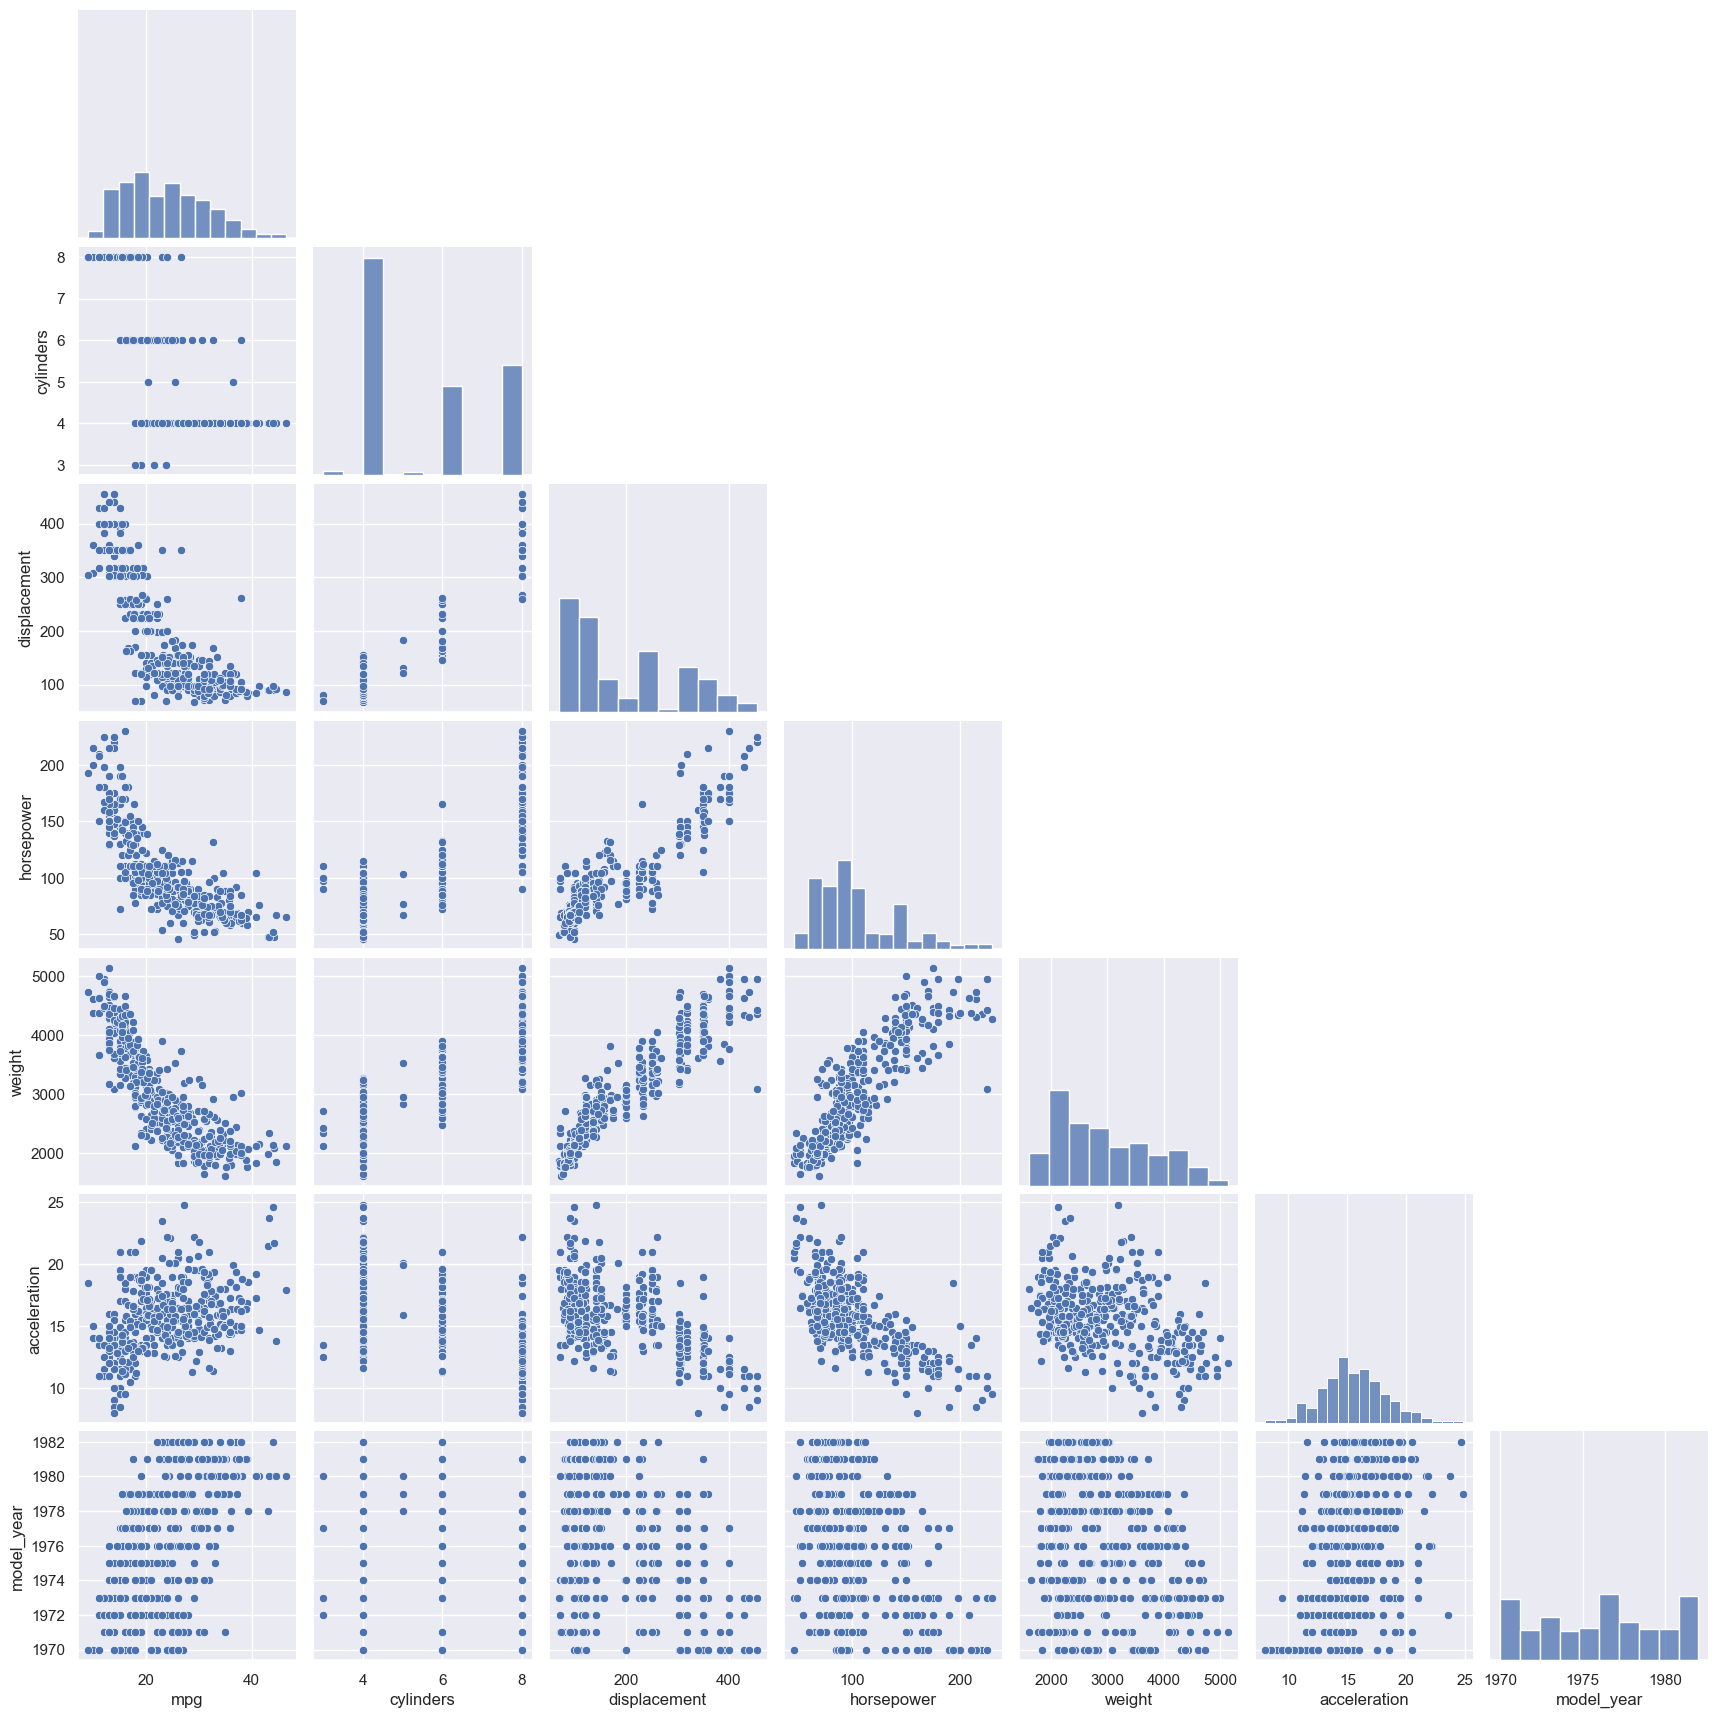

In [22]:
sns.pairplot(auto_df, corner=True);

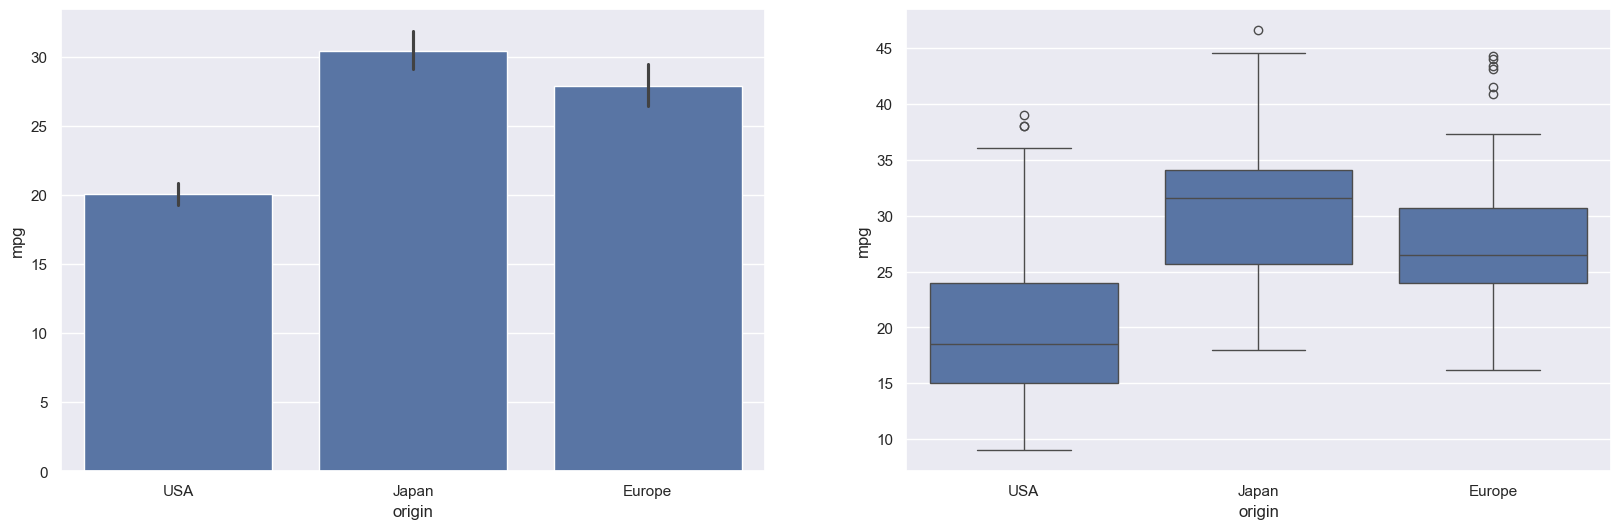

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))

sns.barplot(data=auto_df, x="origin", y="mpg", ax=axs[0])
sns.boxplot(data=auto_df, x="origin", y="mpg", ax=axs[1]);

### EDA Summary
* Apart from acceleration and model_year that has positive correlation values of 0.42 and 0.58 respectively, all other numeric features has a negative relationship with mpg.
* All numeric features are correlated with each other signalling a serious issue of multicollinearity.
* From the scatterplot, it shows that the features `displacement`, `horsepower`, and `weight` do posses a curvilinear relationship with mpg. Feature engineering will be carried out in other for the model to capture the trend.
* Japanes vehicles are the most fuel-efficient on average, European vehicles are moderate, and US vehicles lag behind in mpg.

 

In [24]:
# Dropping car_name due to high-cardinality
auto_df = pd.get_dummies(auto_df.drop("car_name", axis=1), drop_first=True, dtype=int)
auto_df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin_Japan,origin_USA
0,18.0,8,307.0,130.0,3504,12.0,1970,0,1
1,15.0,8,350.0,165.0,3693,11.5,1970,0,1
2,18.0,8,318.0,150.0,3436,11.0,1970,0,1
3,16.0,8,304.0,150.0,3433,12.0,1970,0,1
4,17.0,8,302.0,140.0,3449,10.5,1970,0,1


# Modelling

## Baseline model

Using the feature that is most correlated with target(mpg) as my basline predictor variable

In [25]:
base_X = sm.add_constant(auto_df["weight"])
base_y = auto_df["mpg"]

# Split the data
base_X_train, base_X_test, base_y_train, base_y_test = train_test_split(base_X, base_y, test_size=.20, random_state=2026)

In [26]:
# Cross validation 
def cross_validation(predictors, target):
    kf = KFold(n_splits=5, shuffle=True, random_state=2026)

    # List to store scores
    cv_r2 = []
    cv_mae = []

    # loop through each fold in X and y
    for train_ind, val_ind in kf.split(predictors, target):

        # subset data based on cv folds
        X_train, y_train = predictors.iloc[train_ind], target.iloc[train_ind]
        X_val, y_val = predictors.iloc[val_ind], target.iloc[val_ind]

        # fit model on each fold training data
        model = sm.OLS(y_train, X_train).fit()

        # model prediction
        y_pred = model.predict(X_val)

        # append val scores to lists
        cv_r2.append(r2(y_val, y_pred))
        cv_mae.append(mae(y_val, y_pred))

    cross_val_r2 = f"{round(np.mean(cv_r2), 3)} +- {round(np.std(cv_r2), 3)}"
    cross_val_mae = f"{round(np.mean(cv_mae), 3)} +- {round(np.std(cv_mae), 3)}"

    # final model
    final_model = sm.OLS(target, predictors).fit()

    return final_model, cross_val_r2, cross_val_mae, cv_r2, cv_mae

In [38]:
base_model, base_cross_val_r2, base_cross_val_mae, base_r2_scores, base_mae_scores = cross_validation(base_X_train, base_y_train)

print(f"Base Model All R2 Scores: {base_r2_scores}")
print(f"Base Model Cross Validation R2: {base_cross_val_r2}")
print(f"Base Model All MAE Scores: {base_mae_scores}")
print(f"Base Model Cross Validation MAE: {base_cross_val_mae}")

Base Model All R2 Scores: [0.6744048766624903, 0.7078264549258226, 0.658155914071257, 0.6302638813775936, 0.7129323667514391]
Base Model Cross Validation R2: 0.677 +- 0.031
Base Model All MAE Scores: [3.760391507591427, 3.4065562232026094, 3.0544038229930877, 3.6024566866391794, 2.962443045930836]
Base Model Cross Validation MAE: 3.357 +- 0.307


In [34]:
def residual_analysis(model):
    predictions = model.predict()
    residual = model.resid

    fig, axs = plt.subplots(1, 2, figsize=(20, 6), sharey="all")

    sns.scatterplot(x=predictions, y=residual, ax=axs[0])
    axs[0].set_title("Residual Plot")
    axs[0].set_xlabel("Prediction")
    axs[0].set_ylabel("Residual")

    stats.probplot(residual, dist="norm", plot=axs[1])
    axs[1].set_title("Normal Q-Q Plot")

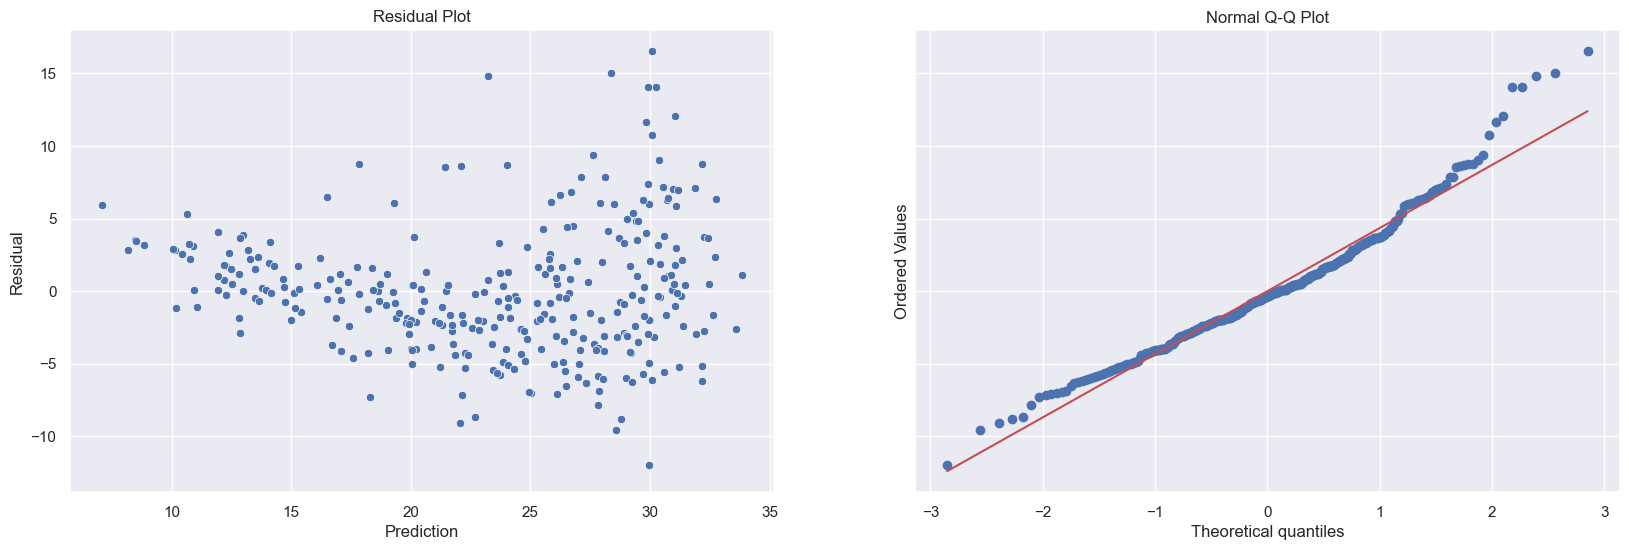

In [35]:
residual_analysis(base_model)

In [36]:
# Base Model scoring
base_y_pred = base_model.predict(base_X_test)

print(f"Base Model Test MAE Score: {mae(base_y_test, base_y_pred)}")
print(f"Base Model Test R2 Score: {r2(base_y_test, base_y_pred)}")

Base Model Test MAE Score: 3.174347342343094
Base Model Test R2 Score: 0.7063228462979101


* The baseline model was able to explain 70.6% variation in our target(mpg) that is not explained by the mean of mpg.
* From the residual analysis plots, it clearly suggests that the linear assusmption is incorrect thereby suggesting a non-linear model may be appropriate.

## Multiple Linear Regression

In [33]:
X = sm.add_constant(auto_df.drop("mpg", axis=1))
y = auto_df["mpg"]

In [37]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=2026)

In [39]:
# Fit model and return validation score using cross validation
model, cross_val_r2, cross_val_mae, r2_scores, mae_scores = cross_validation(X_train, y_train)

print(f"Base Model All R2 Scores: {r2_scores}")
print(f"Base Model Cross Validation R2: {cross_val_r2}")
print(f"\nBase Model All MAE Scores: {mae_scores}")
print(f"Base Model Cross Validation MAE: {cross_val_mae}")

Base Model All R2 Scores: [0.7670276238901748, 0.8326823156621472, 0.7440383645488482, 0.8183610177783611, 0.780488638959208]
Base Model Cross Validation R2: 0.789 +- 0.033

Base Model All MAE Scores: [3.2798365965041105, 2.5355499379704334, 2.8487573752496806, 2.401392752568736, 2.7050645418239587]
Base Model Cross Validation MAE: 2.754 +- 0.303


In [40]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     172.9
Date:                Mon, 02 Feb 2026   Prob (F-statistic):          2.86e-109
Time:                        12:59:09   Log-Likelihood:                -836.12
No. Observations:                 318   AIC:                             1690.
Df Residuals:                     309   BIC:                             1724.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -1480.6859    115.666    -12.801      0.000   -1708.278   -1253.094
cylinders       -0.4693      0.359     -1.307      0.192      -1.176       0.237
displacement     0.0261      0.009      3.045      0.003       0.009       0.043
horsepower      -0.0155      0.014     -1.075      0.283      -0.044       0.013
weight          -0.0069      0.001     -9.640      0.000      -0.008      -0.006
acceleration     0.1582      0.111      1.424      0.155      -0.060       0.377
model_year       0.7709      0.058     13.183      0.000       0.656       0.886
origin_Japan    -0.1224      0.638     -0.192      0.848      -1.378       1.134
origin_USA      -3.0942      0.653     -4.741      0.000      -4.378      -1.810
==============================================================================
Omnibus:                       12.288   Durbin-Watson:                   1.841
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               15.802
Skew:                           0.331   Prob(JB):                     0.000370
Kurtosis:                       3.868   Cond. No.                     2.22e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.22e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

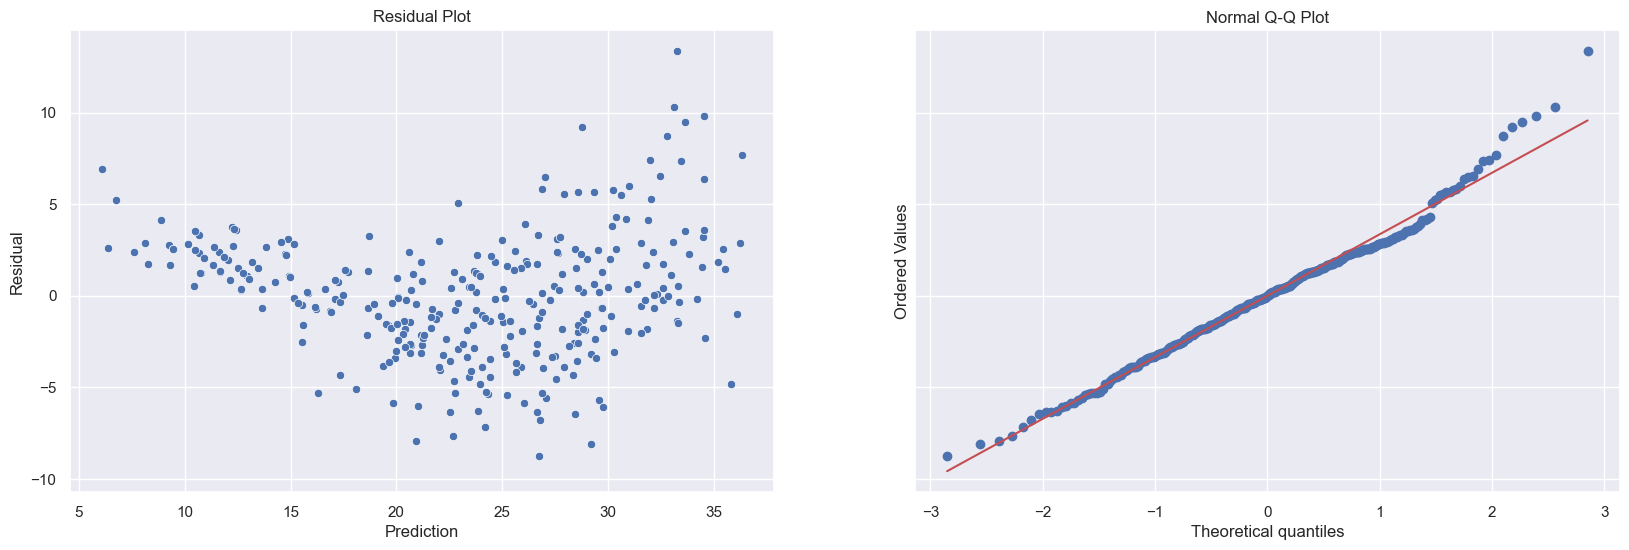

In [41]:
# residual analysis
residual_analysis(model)